In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import datetime as dt
import calendar as cal
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect

In [2]:
# Create engine to hawaii.sqlite
engine = create_engine("sqlite:///../resources/hawaii.sqlite")

# Reflect Tables into SQLAlchemy ORM

In [3]:
# Reflect an existing database into a new model
Base = automap_base()

# Reflect the tables
Base.prepare(engine, reflect=True)

In [4]:
# View all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [5]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [6]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Precipitation Analysis

In [7]:
# Inspect the Measurement class to find the column names and types
inspector = inspect(engine)
columns = inspector.get_columns('Measurement')
for column in columns:
    print(column["name"], column["type"])

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


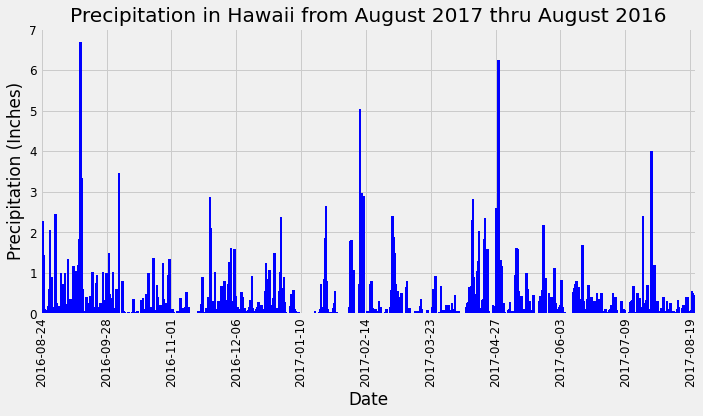

In [8]:
# Query the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database. 
recent_date = session.query(func.max(Measurement.date)).scalar()
recent_date = dt.datetime.strptime(recent_date, '%Y-%m-%d')
query_date = recent_date - dt.timedelta(days=365)

# Perform a query to retrieve the data and precipitation scores
rain_year = session.query(Measurement.date, Measurement.prcp).\
        filter(Measurement.date <= recent_date).\
        filter(Measurement.date >= query_date).\
        order_by(Measurement.date).all()

# Save the query results as a Pandas DataFrame and set the index to the date column
rain_df = pd.DataFrame(rain_year, columns=['Date', 'Precipitation']).dropna()
rain_df.set_index('Date', inplace=True)
rain_sorted = rain_df.sort_values(by="Date")

# Sort the dataframe by date
ax = rain_sorted.plot.bar(color='blue', figsize=(10,6), width=8, legend=False)
ax.xaxis.set_ticks(np.arange(0, len(rain_sorted.index), 200))
ax.xaxis.set_ticklabels(rain_sorted.index.values[::200])

# Use Pandas Plotting with Matplotlib to plot the data
plt.title(f'Precipitation in Hawaii from {cal.month_name[recent_date.month]} {recent_date.year} thru {cal.month_name[query_date.month]} {query_date.year}')
plt.xlabel('Date')
plt.ylabel('Precipitation (Inches)')
plt.xticks(fontsize = 12, rotation = 90)
plt.yticks(fontsize = 12)

# Saving plot to output as png
output_image = f'../output/hawaii_precipitation.png'
plt.tight_layout()
plt.savefig(output_image)

plt.show()


In [9]:
# Use Pandas to calcualte the summary statistics for the precipitation data
rain_df.describe()

,Precipitation
count,2015.000000
mean,0.176462
std,0.460288
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


# Exploratory Station Analysis

In [10]:
# Design a query to calculate the total number stations in the dataset
inspector = inspect(engine)
columns = inspector.get_columns('Station')
for column in columns:
    print(column["name"], column["type"])

id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


In [11]:
# Design a query to calculate the total number stations in the dataset
num_stations = session.query(Station.id).count()
print(f'Number of Stations: {num_stations}')

Number of Stations: 9


In [14]:
# Design a query to find the most active stations (i.e. what stations have the most rows?)
# List the stations and the counts in descending order.
most_active = session.query(Measurement.station, func.count(Measurement.station)).group_by(Measurement.station).order_by(func.count(Measurement.station).desc()).all()
most_active_df = pd.DataFrame(most_active, columns =['Station', 'Measurement Count'])
most_active_df

,Station,Measurement Count
0,USC00519281,2772
1,USC00519397,2724
2,USC00513117,2709
3,USC00519523,2669
4,USC00516128,2612
5,USC00514830,2202
6,USC00511918,1979
7,USC00517948,1372
8,USC00518838,511


In [15]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
most_active_info = session.query(func.min(Measurement.tobs), func.max(Measurement.tobs), func.avg(Measurement.tobs)).filter(Measurement.station == most_active[0][0]).all()

# Printing the statistics found for most active station 
stat_str = f"Most Active Station Statistics\n"
stat_str += f"Station Name: {most_active[0][0]}\n"
stat_str += f"Min Temperature: {most_active_info[0][0]}\n"
stat_str += f"Max Temperature: {most_active_info[0][1]}\n"
stat_str += f"Avg Temparature: {round(most_active_info[0][2],2)}\n"
print(stat_str)

Most Active Station Statistics
Station Name: USC00519281
Min Temperature: 54.0
Max Temperature: 85.0
Avg Temparature: 71.66



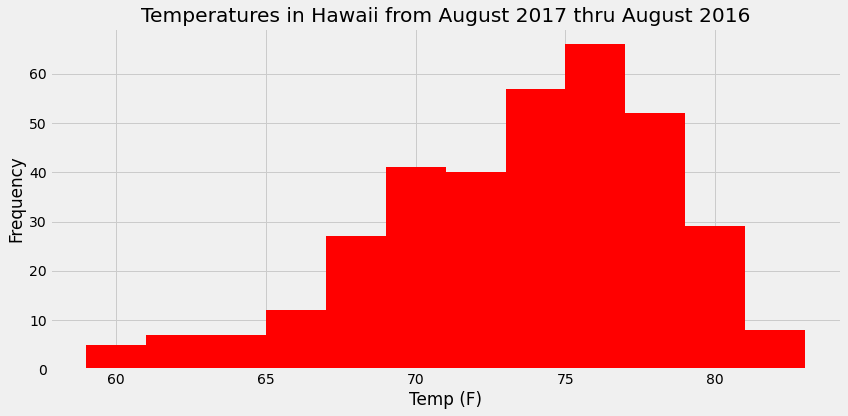

In [16]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
temp_year = session.query(Measurement.tobs).\
        filter(Measurement.date <= recent_date).\
        filter(Measurement.date >= query_date).\
        filter(Measurement.station == most_active[0][0]).all()

# Save the query results as a Pandas DataFrame
temp_df = pd.DataFrame(temp_year, columns=['Temp'])
temp_fixed = temp_df.dropna()

# Creating a histogram of the temperatures and their frequency
temp_fixed.plot.hist(bins=12, color='red', figsize=(12,6), legend=False)

# Plot labels
plt.title(f'Temperatures in Hawaii from {cal.month_name[recent_date.month]} {recent_date.year} thru {cal.month_name[query_date.month]} {query_date.year}')
plt.xlabel('Temp (F)')
plt.ylabel('Frequency')

# Saving plot to output as png
output_image = f'../output/hawaii_temp.png'
plt.tight_layout()
plt.savefig(output_image)

plt.show()

# Close session

In [17]:
# Close Session
session.close()